<a href="https://colab.research.google.com/github/MovinduSenura/Chest-Xray-Pneumonia-Detection/blob/dev-senura/notebooks/CustomCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# ===============================
# 0️⃣ Imports (keep your existing)
# ===============================
import os
import sys
import importlib
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime
import csv
import pandas as pd

# ===============================
# 1️⃣ Clone GitHub repo
# ===============================
if not os.path.exists('Chest-Xray-Pneumonia-Detection'):
    !git clone https://github.com/MovinduSenura/Chest-Xray-Pneumonia-Detection.git
sys.path.append('/content/Chest-Xray-Pneumonia-Detection/notebooks/')

# ===============================
# 2️⃣ Import preprocessing module
# ===============================
import preprocessing
importlib.reload(preprocessing)
from preprocessing import create_generators

# ===============================
# 3️⃣ Mount Google Drive
# ===============================
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/DL_Assignment/chest_xray/'

# ===============================
# 4️⃣ Create data generators
# ===============================
train_gen, val_gen, test_gen = create_generators(DATA_DIR)
print("✅ Data generators created successfully!\n")

# Reduce image size for CPU
train_gen.target_size = (128,128)
val_gen.target_size = (128,128)
test_gen.target_size = (128,128)

# ===============================
# 5️⃣ Handle class imbalance
# ===============================
# Compute class weights for imbalanced dataset
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# ===============================
# 6️⃣ Build optimized Custom CNN
# ===============================
model = Sequential([
    # Convolutional Block 1
    Conv2D(16, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.0005), input_shape=(128,128,3)),
    BatchNormalization(),
    Conv2D(16, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Convolutional Block 2
    Conv2D(32, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Convolutional Block 3
    Conv2D(64, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    # Global Average Pooling
    GlobalAveragePooling2D(),

    # Fully Connected Layers
    Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
model.summary()

# ===============================
# 7️⃣ Callbacks
# ===============================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/DL_Assignment/Results/best_model_cpu.keras',
                    monitor='val_accuracy', save_best_only=True, verbose=1)
]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
✅ Data generators created successfully!

Class Weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 89,617 (350.07 KB)

 Trainable params: 89,169 (348.32 KB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
# ===============================
# 8️⃣ Train the model
# ===============================
print("\n🚀 Starting optimized CPU training...\n")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,             # use more than 3 epochs
    callbacks=callbacks,
    class_weight=class_weights,  # <<< here
    verbose=1
)




🚀 Starting optimized CPU training...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Precision: 0.9003 - Recall: 0.7267 - accuracy: 0.7402 - loss: 0.6652
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/DL_Assignment/Results/best_model_cpu.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 412s 2s/step - Precision: 0.9006 - Recall: 0.7271 - accuracy: 0.7407 - loss: 0.6645 - val_Precision: 0.5000 - val_Recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 3.3109 - learning_rate: 5.0000e-04
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - Precision: 0.9770 - Recall: 0.8685 - accuracy: 0.8875 - loss: 0.4412
Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 412s 3s/step - Precision: 0.9770 - Recall: 0.8685 - accuracy: 0.8875 - loss: 0.4412 - val_Precision: 0.5000 - val_Recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 2.9202 - learning_rate: 5.0000e-04
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Precision: 0.9737 - Recall: 0.8830 - accuracy: 0.8955 - loss:

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 728ms/step - Precision: 0.5333 - Recall: 0.5933 - accuracy: 0.8798 - loss: 0.3929

✅ Test Accuracy: 0.8750
✅ Precision: 0.9127, Recall: 0.8846, F1: 0.8984
✅ Test Loss: 0.4136


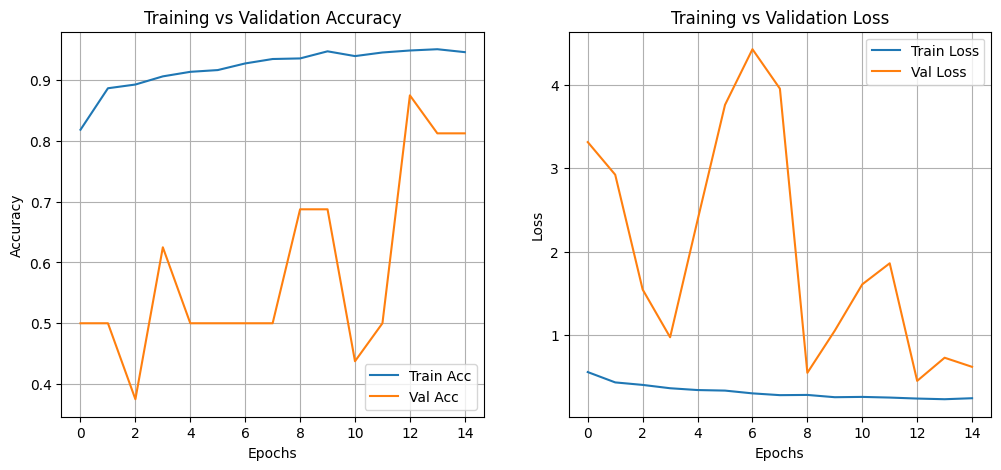

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 688ms/step


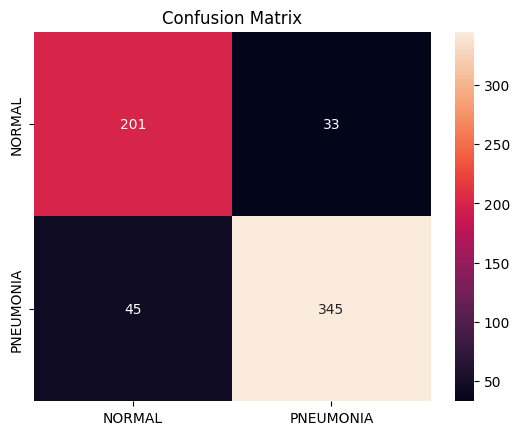

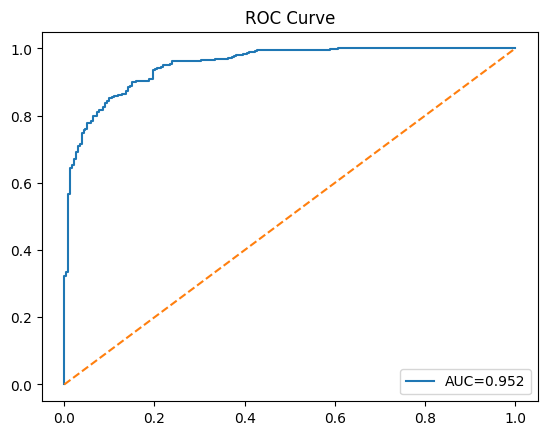

ROC AUC Score: 0.9520
✅ Model saved successfully!
✅ Metrics logged to /content/drive/MyDrive/DL_Assignment/Results/training_logs.csv


In [10]:
# ===============================
# 9️⃣ Evaluate on test data
# ===============================
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_gen)
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

# ===============================
# 10️⃣ Plot training curves
# ===============================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.show()

# ===============================
# 11️⃣ Confusion Matrix & ROC
# ===============================
y_pred = model.predict(test_gen)
y_pred_classes = np.where(y_pred>0.5,1,0).flatten()
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix'); plt.show()

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}'); plt.plot([0,1],[0,1],'--'); plt.title('ROC Curve'); plt.legend(); plt.show()
print(f"ROC AUC Score: {roc_auc:.4f}")

# ===============================
# 12️⃣ Save model & log results
# ===============================
model.save('/content/drive/MyDrive/DL_Assignment/Results/CustomCNN_Optimized.keras')
print("✅ Model saved successfully!")

# Log metrics to CSV (same as your original logging)
log_file = '/content/drive/MyDrive/DL_Assignment/Results/training_logs.csv'
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
row = [
    timestamp,
    history.history['accuracy'][-1],
    history.history['val_accuracy'][-1],
    history.history['loss'][-1],
    history.history['val_loss'][-1],
    history.history['Precision'][-1],
    history.history['val_Precision'][-1],
    history.history['Recall'][-1],
    history.history['val_Recall'][-1],
    max(history.history['val_accuracy']),
    min(history.history['val_loss']),
    test_acc, test_loss, test_precision, test_recall, test_f1, roc_auc,
    len(history.history['accuracy']),
    history.history['accuracy'][-1]-history.history['val_accuracy'][-1],
    model.count_params()
]
if not os.path.exists(log_file):
    with open(log_file,'w',newline='') as f:
        writer = csv.writer(f)
        header = ['Timestamp','Train_Acc','Val_Acc','Train_Loss','Val_Loss',
                  'Train_Precision','Val_Precision','Train_Recall','Val_Recall',
                  'Best_Val_Acc','Best_Val_Loss',
                  'Test_Acc','Test_Loss','Test_Precision','Test_Recall','Test_F1','Test_ROC_AUC',
                  'Epochs_Trained','Overfitting_Gap','Total_Params']
        writer.writerow(header)
        writer.writerow(row)
else:
    with open(log_file,'a',newline='') as f:
        writer = csv.writer(f)
        writer.writerow(row)
print(f"✅ Metrics logged to {log_file}")